In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import time
import pickle
from joblib import dump, load

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
pd.options.display.precision = 2
pd.options.display.max_rows = 50

In [3]:
stations = pd.read_csv('../Data/live_stations.csv')
outgoingDF = pd.read_pickle("../Data/outgoingDF.pkl")
incomingDF = pd.read_pickle("../Data/incomingDF.pkl")

#### problem: <i>start station id has multiple lat & long information

### Construct a DataFrame for each Bike Station/Time Interval:

In [4]:
# # import station_dict
import pickle
station_dict = pickle.load(open("../Data/station_dict.pkl", "rb"))

### Bike Demand Distribution (Across All Bike Stations)

,outgoing_bike_count
count,1.98e+07
mean,3.19e+00
std,3.47e+00
min,1.00e+00
25%,1.00e+00
50%,2.00e+00
75%,4.00e+00
max,1.57e+02


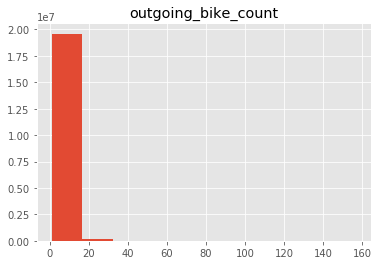

In [5]:
outgoingDF[['outgoing_bike_count']].hist()
outgoingDF[['outgoing_bike_count']].describe()

,incoming_bike_count
count,1.99e+07
mean,3.18e+00
std,3.43e+00
min,1.00e+00
25%,1.00e+00
50%,2.00e+00
75%,4.00e+00
max,1.28e+02


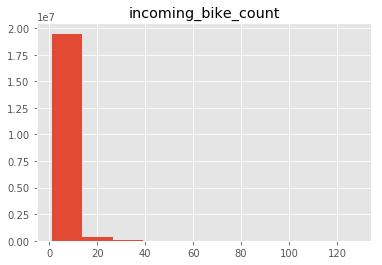

In [6]:
incomingDF[['incoming_bike_count']].hist()
incomingDF[['incoming_bike_count']].describe()

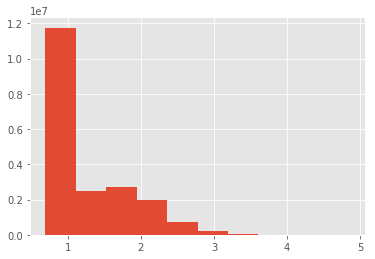

In [7]:
np.log(incomingDF.incoming_bike_count+1).hist()

Taking the natural log doesn't really help much in terms of skewed distribution

In [4]:
outgoingDF.bike_demand.value_counts()

Medium    8280830
Low       7488842
High      4029836
Name: bike_demand, dtype: int64

In [118]:
outgoingDF['cnt']=pd.Series(np.ones(len(outgoingDF.bike_demand)))
incomingDF['cnt']=pd.Series(np.ones(len(incomingDF.dock_demand)))

In [195]:
temp=pd.DataFrame(outgoingDF.groupby(['start station id','season','dayofweek','starttime_interval','bike_demand']).\
             cnt.sum().reset_index())
outgoing=temp[temp.groupby(['start station id','season','dayofweek','starttime_interval'])['cnt'].\
     transform(max) == temp['cnt'] ]
outgoing=outgoing.groupby(['start station id','season','dayofweek','starttime_interval'])\
['bike_demand'].first().reset_index()

In [206]:
temp=pd.DataFrame(incomingDF.groupby(['end station id','season','dayofweek','stoptime_interval','dock_demand']).\
            cnt.sum().reset_index())
incoming=temp[temp.groupby(['end station id','season','dayofweek','stoptime_interval'])['cnt'].\
     transform(max) == temp['cnt'] ]
incoming=incoming.groupby(['end station id','season','dayofweek','stoptime_interval'])\
['dock_demand'].first().reset_index()

In [141]:
X=outgoingDF[['start station id','season','dayofweek','starttime_interval']]
prediction=pd.merge(X, outgoing, how='inner', on=['start station id','season','dayofweek','starttime_interval'])
target=outgoingDF[['bike_demand']]
pred=prediction[['bike_demand']]
accuracy=pd.merge(target, pred, left_index=True, right_index=True)
accuracy.columns=['target','pred']

In [205]:
np.mean(accuracy['pred'] == accuracy['target'] )

0.3589378584558768

In [208]:
X=incomingDF[['end station id','season','dayofweek','stoptime_interval']]
prediction=pd.merge(X, incoming, how='inner', on=['end station id','season','dayofweek','stoptime_interval'])
target=incomingDF[['dock_demand']]
pred=prediction[['dock_demand']]
accuracy=pd.merge(target, pred, left_index=True, right_index=True)
accuracy.columns=['target','pred']

Score of selecting mode of each group

In [209]:
np.mean(accuracy['pred'] == accuracy['target'] )

0.35841802485663393

## Model Selection: Train Different Models on the Sampled Data

In [20]:
sample=outgoingDF.sample(n=1200000, random_state=0)

check sample bike_demand distribution

In [21]:
sample.bike_demand.value_counts()

Medium    502004
Low       453735
High      244261
Name: bike_demand, dtype: int64

In [22]:
sample['dayofweek']=pd.to_datetime(sample.starttime_date).dt.dayofweek
temp=sample.starttime_interval.str.split(":",expand=True)
temp.columns=['hour','min']
temp['hour']=temp['hour'].astype('int32')
temp['min']=temp['min'].astype('int32')
sample=pd.merge(sample,temp,left_index=True, right_index=True)

In [23]:
X=sample.drop(columns=['starttime_date','starttime_interval','outgoing_bike_count','bike_demand'])
y=sample['bike_demand']

Label Encoding

In [24]:
%%time
le = LabelEncoder()
X['season'] = le.fit_transform(X['season'])

CPU times: user 152 ms, sys: 13.8 ms, total: 166 ms
Wall time: 174 ms


Scale

In [25]:
%%time
X_std = StandardScaler().fit_transform(X)

CPU times: user 155 ms, sys: 74.7 ms, total: 230 ms
Wall time: 256 ms


### 1. Random Forest

In [21]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rfc = RandomForestClassifier(random_state=0, verbose=True, n_jobs=-1)
rfc.fit(X_train, y_train)
dump(rfc, '../Models/rfc_sampled.joblib') 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.6s finished


CPU times: user 5min 34s, sys: 19.1 s, total: 5min 53s
Wall time: 1min 49s


['../Models/rfc_sampled.joblib']

In [22]:
rfc.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.1s finished


0.50215

### 2. KNeighbors Classifier

Finding n_neighbors

In [23]:
np.sqrt(X_std.shape[0])

1095.4451150103323

In [24]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=0)

CPU times: user 282 ms, sys: 162 ms, total: 443 ms
Wall time: 460 ms


In [25]:
%%time
knc = KNeighborsClassifier(n_neighbors=1095, n_jobs=-1) # sqrt of X train rownum
knc.fit(X_train, y_train)
dump(knc, '../Models/knc.joblib') 

CPU times: user 1min 20s, sys: 493 ms, total: 1min 20s
Wall time: 1min 20s


['../Models/knc.joblib']

In [27]:
knc.score(X_test, y_test)

0.491525

Check Point: 
So far Random Forest seems to work better than KNN

### 3. SVM

In [28]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=0)

CPU times: user 233 ms, sys: 122 ms, total: 355 ms
Wall time: 428 ms


In [ ]:
%%time
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo', verbose=True)
svclassifier.fit(X_train, y_train)
dump(svclassifier, '../Models/svm_rbf.joblib')

[LibSVM]

In [ ]:
svclassifier.score(X_test, y_test)

SVM Model takes too long to run

### 4. Cat Boost Classifier

In [29]:
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
catB = CatBoostClassifier(iterations=1000)
catB.fit(X_train, y_train)

Learning rate set to 0.11231
0:	learn: 1.0793711	total: 274ms	remaining: 4m 33s
1:	learn: 1.0638282	total: 416ms	remaining: 3m 27s
2:	learn: 1.0511801	total: 565ms	remaining: 3m 7s
3:	learn: 1.0405412	total: 703ms	remaining: 2m 55s
4:	learn: 1.0314740	total: 853ms	remaining: 2m 49s
5:	learn: 1.0235546	total: 990ms	remaining: 2m 44s
6:	learn: 1.0170788	total: 1.14s	remaining: 2m 41s
7:	learn: 1.0117957	total: 1.27s	remaining: 2m 37s
8:	learn: 1.0070936	total: 1.42s	remaining: 2m 36s
9:	learn: 1.0016646	total: 1.56s	remaining: 2m 34s
10:	learn: 0.9981747	total: 1.71s	remaining: 2m 33s
11:	learn: 0.9947776	total: 1.87s	remaining: 2m 33s
12:	learn: 0.9919431	total: 2.02s	remaining: 2m 33s
13:	learn: 0.9893995	total: 2.16s	remaining: 2m 32s
14:	learn: 0.9871200	total: 2.32s	remaining: 2m 32s
15:	learn: 0.9845209	total: 2.45s	remaining: 2m 30s
16:	learn: 0.9825274	total: 2.6s	remaining: 2m 30s
17:	learn: 0.9809254	total: 2.73s	remaining: 2m 28s
18:	learn: 0.9790247	total: 2.87s	remaining: 2m

157:	learn: 0.9259606	total: 24.7s	remaining: 2m 11s
158:	learn: 0.9258973	total: 24.8s	remaining: 2m 11s
159:	learn: 0.9257579	total: 25s	remaining: 2m 11s
160:	learn: 0.9256633	total: 25.1s	remaining: 2m 10s
161:	learn: 0.9254524	total: 25.3s	remaining: 2m 10s
162:	learn: 0.9252660	total: 25.4s	remaining: 2m 10s
163:	learn: 0.9250776	total: 25.6s	remaining: 2m 10s
164:	learn: 0.9248460	total: 25.7s	remaining: 2m 10s
165:	learn: 0.9247031	total: 25.9s	remaining: 2m 9s
166:	learn: 0.9245901	total: 26s	remaining: 2m 9s
167:	learn: 0.9242864	total: 26.2s	remaining: 2m 9s
168:	learn: 0.9241559	total: 26.3s	remaining: 2m 9s
169:	learn: 0.9241026	total: 26.5s	remaining: 2m 9s
170:	learn: 0.9239648	total: 26.6s	remaining: 2m 9s
171:	learn: 0.9238886	total: 26.8s	remaining: 2m 8s
172:	learn: 0.9238394	total: 26.9s	remaining: 2m 8s
173:	learn: 0.9237393	total: 27.1s	remaining: 2m 8s
174:	learn: 0.9236567	total: 27.2s	remaining: 2m 8s
175:	learn: 0.9234953	total: 27.4s	remaining: 2m 8s
176:	lea

315:	learn: 0.9112205	total: 49.8s	remaining: 1m 47s
316:	learn: 0.9111527	total: 49.9s	remaining: 1m 47s
317:	learn: 0.9110669	total: 50.1s	remaining: 1m 47s
318:	learn: 0.9110464	total: 50.2s	remaining: 1m 47s
319:	learn: 0.9109995	total: 50.4s	remaining: 1m 46s
320:	learn: 0.9109249	total: 50.5s	remaining: 1m 46s
321:	learn: 0.9108427	total: 50.6s	remaining: 1m 46s
322:	learn: 0.9108272	total: 50.8s	remaining: 1m 46s
323:	learn: 0.9107802	total: 50.9s	remaining: 1m 46s
324:	learn: 0.9107549	total: 51.1s	remaining: 1m 46s
325:	learn: 0.9106850	total: 51.2s	remaining: 1m 45s
326:	learn: 0.9106673	total: 51.4s	remaining: 1m 45s
327:	learn: 0.9105991	total: 51.5s	remaining: 1m 45s
328:	learn: 0.9105214	total: 51.7s	remaining: 1m 45s
329:	learn: 0.9104775	total: 51.8s	remaining: 1m 45s
330:	learn: 0.9104433	total: 52s	remaining: 1m 45s
331:	learn: 0.9103539	total: 52.1s	remaining: 1m 44s
332:	learn: 0.9103349	total: 52.3s	remaining: 1m 44s
333:	learn: 0.9102508	total: 52.4s	remaining: 1m

470:	learn: 0.9044346	total: 1m 13s	remaining: 1m 22s
471:	learn: 0.9044173	total: 1m 13s	remaining: 1m 22s
472:	learn: 0.9043720	total: 1m 13s	remaining: 1m 21s
473:	learn: 0.9043323	total: 1m 13s	remaining: 1m 21s
474:	learn: 0.9042917	total: 1m 13s	remaining: 1m 21s
475:	learn: 0.9042784	total: 1m 13s	remaining: 1m 21s
476:	learn: 0.9042406	total: 1m 14s	remaining: 1m 21s
477:	learn: 0.9042000	total: 1m 14s	remaining: 1m 21s
478:	learn: 0.9041500	total: 1m 14s	remaining: 1m 20s
479:	learn: 0.9041391	total: 1m 14s	remaining: 1m 20s
480:	learn: 0.9041278	total: 1m 14s	remaining: 1m 20s
481:	learn: 0.9040906	total: 1m 14s	remaining: 1m 20s
482:	learn: 0.9040799	total: 1m 15s	remaining: 1m 20s
483:	learn: 0.9040346	total: 1m 15s	remaining: 1m 20s
484:	learn: 0.9039910	total: 1m 15s	remaining: 1m 19s
485:	learn: 0.9039185	total: 1m 15s	remaining: 1m 19s
486:	learn: 0.9038205	total: 1m 15s	remaining: 1m 19s
487:	learn: 0.9037869	total: 1m 15s	remaining: 1m 19s
488:	learn: 0.9037365	total:

625:	learn: 0.8997326	total: 1m 37s	remaining: 58.2s
626:	learn: 0.8997015	total: 1m 37s	remaining: 58.1s
627:	learn: 0.8996784	total: 1m 37s	remaining: 57.9s
628:	learn: 0.8996529	total: 1m 37s	remaining: 57.8s
629:	learn: 0.8996335	total: 1m 38s	remaining: 57.6s
630:	learn: 0.8996069	total: 1m 38s	remaining: 57.4s
631:	learn: 0.8995910	total: 1m 38s	remaining: 57.3s
632:	learn: 0.8995667	total: 1m 38s	remaining: 57.1s
633:	learn: 0.8995533	total: 1m 38s	remaining: 57s
634:	learn: 0.8995429	total: 1m 38s	remaining: 56.8s
635:	learn: 0.8995196	total: 1m 38s	remaining: 56.7s
636:	learn: 0.8994947	total: 1m 39s	remaining: 56.5s
637:	learn: 0.8994879	total: 1m 39s	remaining: 56.3s
638:	learn: 0.8994747	total: 1m 39s	remaining: 56.2s
639:	learn: 0.8994477	total: 1m 39s	remaining: 56s
640:	learn: 0.8994248	total: 1m 39s	remaining: 55.9s
641:	learn: 0.8993947	total: 1m 39s	remaining: 55.7s
642:	learn: 0.8993614	total: 1m 40s	remaining: 55.5s
643:	learn: 0.8993515	total: 1m 40s	remaining: 55.

782:	learn: 0.8969661	total: 2m 2s	remaining: 34.1s
783:	learn: 0.8969486	total: 2m 3s	remaining: 33.9s
784:	learn: 0.8969389	total: 2m 3s	remaining: 33.8s
785:	learn: 0.8969350	total: 2m 3s	remaining: 33.6s
786:	learn: 0.8969263	total: 2m 3s	remaining: 33.5s
787:	learn: 0.8969145	total: 2m 3s	remaining: 33.3s
788:	learn: 0.8969042	total: 2m 3s	remaining: 33.2s
789:	learn: 0.8968814	total: 2m 4s	remaining: 33s
790:	learn: 0.8968524	total: 2m 4s	remaining: 32.8s
791:	learn: 0.8968279	total: 2m 4s	remaining: 32.7s
792:	learn: 0.8967962	total: 2m 4s	remaining: 32.5s
793:	learn: 0.8967925	total: 2m 4s	remaining: 32.4s
794:	learn: 0.8967627	total: 2m 4s	remaining: 32.2s
795:	learn: 0.8967409	total: 2m 5s	remaining: 32.1s
796:	learn: 0.8967304	total: 2m 5s	remaining: 31.9s
797:	learn: 0.8967146	total: 2m 5s	remaining: 31.8s
798:	learn: 0.8967057	total: 2m 5s	remaining: 31.6s
799:	learn: 0.8966872	total: 2m 5s	remaining: 31.4s
800:	learn: 0.8966827	total: 2m 5s	remaining: 31.3s
801:	learn: 0.

939:	learn: 0.8945209	total: 2m 30s	remaining: 9.58s
940:	learn: 0.8945147	total: 2m 30s	remaining: 9.42s
941:	learn: 0.8945039	total: 2m 30s	remaining: 9.26s
942:	learn: 0.8944953	total: 2m 30s	remaining: 9.1s
943:	learn: 0.8944855	total: 2m 30s	remaining: 8.94s
944:	learn: 0.8944666	total: 2m 30s	remaining: 8.78s
945:	learn: 0.8944522	total: 2m 30s	remaining: 8.62s
946:	learn: 0.8944485	total: 2m 31s	remaining: 8.46s
947:	learn: 0.8944317	total: 2m 31s	remaining: 8.3s
948:	learn: 0.8944106	total: 2m 31s	remaining: 8.14s
949:	learn: 0.8944016	total: 2m 31s	remaining: 7.98s
950:	learn: 0.8943924	total: 2m 31s	remaining: 7.82s
951:	learn: 0.8943883	total: 2m 31s	remaining: 7.66s
952:	learn: 0.8943829	total: 2m 32s	remaining: 7.5s
953:	learn: 0.8943754	total: 2m 32s	remaining: 7.34s
954:	learn: 0.8943645	total: 2m 32s	remaining: 7.19s
955:	learn: 0.8943383	total: 2m 32s	remaining: 7.03s
956:	learn: 0.8943305	total: 2m 32s	remaining: 6.87s
957:	learn: 0.8943215	total: 2m 33s	remaining: 6.

In [30]:
catB.score(X_test, y_test)

0.543025

Cat Boost Scores higher than Random Forest.

## Bike Demand Model

Feature Engineering

In [33]:
X=outgoingDF
X['dayofweek']=pd.to_datetime(X.starttime_date).dt.dayofweek
temp=X.starttime_interval.str.split(":",expand=True)
temp.columns=['hour','min']
temp['hour']=temp['hour'].astype('int32')
temp['min']=temp['min'].astype('int32')
X=pd.merge(X,temp,left_index=True, right_index=True)

In [34]:
X=X.drop(columns=['starttime_date','starttime_interval','outgoing_bike_count','bike_demand'])
y=outgoingDF['bike_demand']

In [35]:
%%time
le = LabelEncoder()
X['season'] = le.fit_transform(X['season'])

CPU times: user 2.16 s, sys: 131 ms, total: 2.29 s
Wall time: 2.3 s


In [36]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

CPU times: user 6.79 s, sys: 1 s, total: 7.79 s
Wall time: 7.94 s


### CatBoost Model

In [37]:
%%time
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
catB_bike = CatBoostClassifier(iterations=1000)
catB_bike.fit(X_train, y_train)
dump(catB_bike, '../Models/catB_bike.joblib')

Learning rate set to 0.129572
0:	learn: 1.0765674	total: 6.71s	remaining: 1h 51m 45s
1:	learn: 1.0593682	total: 11.2s	remaining: 1h 33m 12s
2:	learn: 1.0453284	total: 17.9s	remaining: 1h 39m 17s
3:	learn: 1.0335752	total: 23.4s	remaining: 1h 37m
4:	learn: 1.0244037	total: 33.2s	remaining: 1h 49m 59s
5:	learn: 1.0169897	total: 39.9s	remaining: 1h 50m 5s
6:	learn: 1.0097525	total: 50.2s	remaining: 1h 58m 38s
7:	learn: 1.0045123	total: 54s	remaining: 1h 51m 38s
8:	learn: 0.9988703	total: 59.4s	remaining: 1h 49m 3s
9:	learn: 0.9947215	total: 1m 4s	remaining: 1h 45m 39s
10:	learn: 0.9913372	total: 1m 8s	remaining: 1h 42m 39s
11:	learn: 0.9883130	total: 1m 13s	remaining: 1h 40m 20s
12:	learn: 0.9855388	total: 1m 17s	remaining: 1h 37m 37s
13:	learn: 0.9833575	total: 1m 25s	remaining: 1h 39m 52s
14:	learn: 0.9808623	total: 1m 28s	remaining: 1h 37m 19s
15:	learn: 0.9790236	total: 1m 32s	remaining: 1h 34m 21s
16:	learn: 0.9774631	total: 1m 35s	remaining: 1h 32m 15s
17:	learn: 0.9760407	total: 1m

144:	learn: 0.9243579	total: 11m 16s	remaining: 1h 6m 27s
145:	learn: 0.9241461	total: 11m 20s	remaining: 1h 6m 17s
146:	learn: 0.9237572	total: 11m 23s	remaining: 1h 6m 4s
147:	learn: 0.9236846	total: 11m 27s	remaining: 1h 5m 54s
148:	learn: 0.9235555	total: 11m 30s	remaining: 1h 5m 41s
149:	learn: 0.9235014	total: 11m 32s	remaining: 1h 5m 26s
150:	learn: 0.9234604	total: 11m 35s	remaining: 1h 5m 13s
151:	learn: 0.9232712	total: 11m 38s	remaining: 1h 4m 59s
152:	learn: 0.9231927	total: 11m 41s	remaining: 1h 4m 44s
153:	learn: 0.9229647	total: 11m 44s	remaining: 1h 4m 31s
154:	learn: 0.9228586	total: 11m 47s	remaining: 1h 4m 19s
155:	learn: 0.9227103	total: 11m 50s	remaining: 1h 4m 6s
156:	learn: 0.9225375	total: 11m 53s	remaining: 1h 3m 52s
157:	learn: 0.9223410	total: 11m 56s	remaining: 1h 3m 39s
158:	learn: 0.9222564	total: 11m 59s	remaining: 1h 3m 27s
159:	learn: 0.9220609	total: 12m 3s	remaining: 1h 3m 15s
160:	learn: 0.9219531	total: 12m 5s	remaining: 1h 3m 3s
161:	learn: 0.92190

291:	learn: 0.9109534	total: 18m 47s	remaining: 45m 33s
292:	learn: 0.9108899	total: 18m 50s	remaining: 45m 27s
293:	learn: 0.9108362	total: 18m 53s	remaining: 45m 21s
294:	learn: 0.9107398	total: 18m 56s	remaining: 45m 15s
295:	learn: 0.9106580	total: 18m 59s	remaining: 45m 9s
296:	learn: 0.9106245	total: 19m 2s	remaining: 45m 4s
297:	learn: 0.9104886	total: 19m 5s	remaining: 44m 58s
298:	learn: 0.9104017	total: 19m 8s	remaining: 44m 53s
299:	learn: 0.9103670	total: 19m 11s	remaining: 44m 47s
300:	learn: 0.9103469	total: 19m 14s	remaining: 44m 41s
301:	learn: 0.9102931	total: 19m 17s	remaining: 44m 35s
302:	learn: 0.9102066	total: 19m 20s	remaining: 44m 29s
303:	learn: 0.9101464	total: 19m 23s	remaining: 44m 24s
304:	learn: 0.9100375	total: 19m 27s	remaining: 44m 19s
305:	learn: 0.9099735	total: 19m 30s	remaining: 44m 14s
306:	learn: 0.9099154	total: 19m 33s	remaining: 44m 8s
307:	learn: 0.9098352	total: 19m 36s	remaining: 44m 2s
308:	learn: 0.9097618	total: 19m 39s	remaining: 43m 56s

439:	learn: 0.9041888	total: 26m 34s	remaining: 33m 49s
440:	learn: 0.9041138	total: 26m 37s	remaining: 33m 45s
441:	learn: 0.9040757	total: 26m 41s	remaining: 33m 41s
442:	learn: 0.9040288	total: 26m 44s	remaining: 33m 37s
443:	learn: 0.9039399	total: 26m 47s	remaining: 33m 32s
444:	learn: 0.9039089	total: 26m 50s	remaining: 33m 28s
445:	learn: 0.9038966	total: 26m 53s	remaining: 33m 23s
446:	learn: 0.9038353	total: 26m 56s	remaining: 33m 19s
447:	learn: 0.9038248	total: 26m 58s	remaining: 33m 14s
448:	learn: 0.9038012	total: 27m 2s	remaining: 33m 10s
449:	learn: 0.9037604	total: 27m 5s	remaining: 33m 6s
450:	learn: 0.9037337	total: 27m 8s	remaining: 33m 2s
451:	learn: 0.9037097	total: 27m 11s	remaining: 32m 57s
452:	learn: 0.9036823	total: 27m 14s	remaining: 32m 53s
453:	learn: 0.9036631	total: 27m 17s	remaining: 32m 48s
454:	learn: 0.9036288	total: 27m 20s	remaining: 32m 44s
455:	learn: 0.9035963	total: 27m 23s	remaining: 32m 40s
456:	learn: 0.9035776	total: 27m 26s	remaining: 32m 3

587:	learn: 0.8998822	total: 34m 15s	remaining: 24m
588:	learn: 0.8998599	total: 34m 18s	remaining: 23m 56s
589:	learn: 0.8998390	total: 34m 21s	remaining: 23m 52s
590:	learn: 0.8998132	total: 34m 24s	remaining: 23m 48s
591:	learn: 0.8997942	total: 34m 26s	remaining: 23m 44s
592:	learn: 0.8997684	total: 34m 30s	remaining: 23m 40s
593:	learn: 0.8997616	total: 34m 32s	remaining: 23m 36s
594:	learn: 0.8997420	total: 34m 35s	remaining: 23m 32s
595:	learn: 0.8997039	total: 34m 38s	remaining: 23m 29s
596:	learn: 0.8996962	total: 34m 41s	remaining: 23m 25s
597:	learn: 0.8996837	total: 34m 44s	remaining: 23m 21s
598:	learn: 0.8996771	total: 34m 47s	remaining: 23m 17s
599:	learn: 0.8996286	total: 34m 52s	remaining: 23m 15s
600:	learn: 0.8996039	total: 35m 1s	remaining: 23m 14s
601:	learn: 0.8995980	total: 35m 5s	remaining: 23m 12s
602:	learn: 0.8995498	total: 35m 8s	remaining: 23m 8s
603:	learn: 0.8995210	total: 35m 12s	remaining: 23m 4s
604:	learn: 0.8994959	total: 35m 15s	remaining: 23m 1s
60

735:	learn: 0.8969294	total: 41m 52s	remaining: 15m 1s
736:	learn: 0.8969083	total: 41m 55s	remaining: 14m 57s
737:	learn: 0.8968917	total: 41m 58s	remaining: 14m 54s
738:	learn: 0.8968873	total: 42m 1s	remaining: 14m 50s
739:	learn: 0.8968682	total: 42m 4s	remaining: 14m 46s
740:	learn: 0.8968508	total: 42m 7s	remaining: 14m 43s
741:	learn: 0.8968306	total: 42m 10s	remaining: 14m 39s
742:	learn: 0.8967974	total: 42m 13s	remaining: 14m 36s
743:	learn: 0.8967821	total: 42m 16s	remaining: 14m 32s
744:	learn: 0.8967769	total: 42m 19s	remaining: 14m 29s
745:	learn: 0.8967531	total: 42m 22s	remaining: 14m 25s
746:	learn: 0.8967424	total: 42m 25s	remaining: 14m 22s
747:	learn: 0.8967318	total: 42m 28s	remaining: 14m 18s
748:	learn: 0.8967211	total: 42m 31s	remaining: 14m 15s
749:	learn: 0.8966933	total: 42m 34s	remaining: 14m 11s
750:	learn: 0.8966547	total: 42m 37s	remaining: 14m 7s
751:	learn: 0.8966275	total: 42m 40s	remaining: 14m 4s
752:	learn: 0.8966207	total: 42m 43s	remaining: 14m
75

884:	learn: 0.8946925	total: 49m 27s	remaining: 6m 25s
885:	learn: 0.8946695	total: 49m 30s	remaining: 6m 22s
886:	learn: 0.8946546	total: 49m 33s	remaining: 6m 18s
887:	learn: 0.8946380	total: 49m 36s	remaining: 6m 15s
888:	learn: 0.8946200	total: 49m 39s	remaining: 6m 12s
889:	learn: 0.8946055	total: 49m 42s	remaining: 6m 8s
890:	learn: 0.8946030	total: 49m 45s	remaining: 6m 5s
891:	learn: 0.8946001	total: 49m 48s	remaining: 6m 1s
892:	learn: 0.8945957	total: 49m 51s	remaining: 5m 58s
893:	learn: 0.8945919	total: 49m 54s	remaining: 5m 55s
894:	learn: 0.8945852	total: 49m 57s	remaining: 5m 51s
895:	learn: 0.8945816	total: 50m	remaining: 5m 48s
896:	learn: 0.8945709	total: 50m 3s	remaining: 5m 44s
897:	learn: 0.8945547	total: 50m 7s	remaining: 5m 41s
898:	learn: 0.8945496	total: 50m 10s	remaining: 5m 38s
899:	learn: 0.8945469	total: 50m 13s	remaining: 5m 34s
900:	learn: 0.8945340	total: 50m 16s	remaining: 5m 31s
901:	learn: 0.8945247	total: 50m 19s	remaining: 5m 28s
902:	learn: 0.89450

FileNotFoundError: [Errno 2] No such file or directory: 'Models/catB_bike.joblib'

In [38]:
catB_bike.score(X_test, y_test)

0.5458231037030714

### Random Forest Model

In [42]:
%%time
rfc = RandomForestClassifier(random_state=0, verbose=True, n_jobs=-1)
rfc.fit(X_train, y_train)
dump(rfc, 'Models/rfc_bike.joblib') 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 31.3min finished


CPU times: user 3h 43min 10s, sys: 4min 49s, total: 3h 48min
Wall time: 34min 16s


['rfc.joblib']

In [43]:
rfc.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  5.2min finished


0.6127128414684052

In [44]:
rfc.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished


0.5750258465992341

## Dock Demand Model

### Random Forest

In [5]:
X=incomingDF
X['dayofweek']=pd.to_datetime(X.stoptime_date).dt.dayofweek
temp=X.stoptime_interval.str.split(":",expand=True)
temp.columns=['hour','min']
temp['hour']=temp['hour'].astype('int32')
temp['min']=temp['min'].astype('int32')
X=pd.merge(X,temp,left_index=True, right_index=True)
X.dtypes

end station id          int64
stoptime_date          object
season                 object
dayofweek               int64
stoptime_interval      object
incoming_bike_count     int64
dock_demand            object
hour                    int32
min                     int32
dtype: object

In [11]:
X=X.drop(columns=['stoptime_date','stoptime_interval','incoming_bike_count','dock_demand'])
y=incomingDF['dock_demand']

In [7]:
%%time
le = LabelEncoder()
X['season'] = le.fit_transform(X['season'])

CPU times: user 2.28 s, sys: 150 ms, total: 2.43 s
Wall time: 2.44 s


In [12]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

CPU times: user 6.59 s, sys: 870 ms, total: 7.46 s
Wall time: 7.57 s


In [16]:
rfc = RandomForestClassifier(random_state=0, n_jobs=-1)
rfc.fit(X_train, y_train)
dump(rfc, '..Models/rfc_dock.joblib') 

In [15]:
rfc.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   44.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.0min finished


0.5837129536559376

### Visualize Bike Demands and Dock Demands

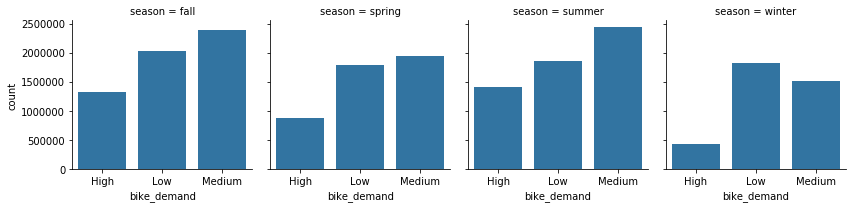

In [73]:
g=sns.FacetGrid(outgoingDF.groupby(['season','bike_demand'])['outgoing_bike_count'].count().reset_index().\
                rename(columns={'outgoing_bike_count':'count'}),col='season', margin_titles=True)
g.map(sns.barplot,'bike_demand', "count")

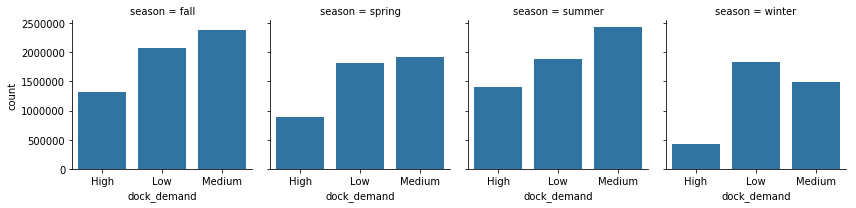

In [74]:
g=sns.FacetGrid(incomingDF.groupby(['season','dock_demand'])['incoming_bike_count'].count().reset_index().\
                rename(columns={'incoming_bike_count':'count'}),col='season', margin_titles=True)
g.map(sns.barplot,'dock_demand', "count")

In [86]:
outgoingDF.starttime_interval=outgoingDF.starttime_interval.swifter.apply(lambda x: '0'+x if len(x)==4 else x)

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


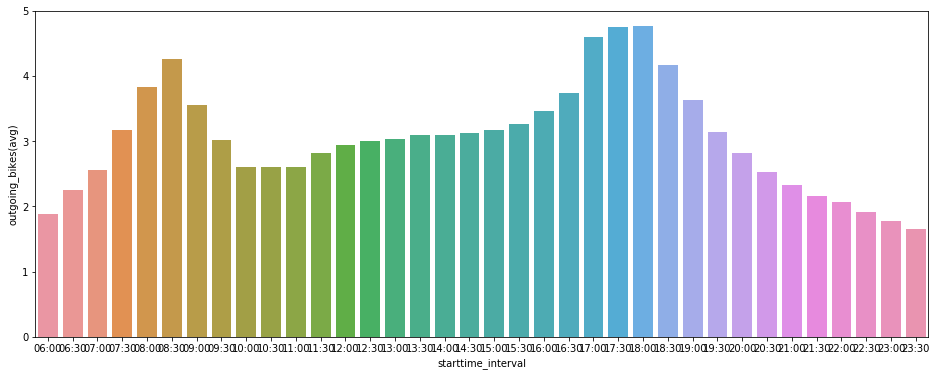

In [94]:
plt.figure(figsize=(16, 6))
sns.barplot('starttime_interval','outgoing_bikes(avg)', data=outgoingDF.groupby(['starttime_interval'])['outgoing_bike_count'].mean().reset_index().\
                rename(columns={'outgoing_bike_count':'outgoing_bikes(avg)'}))

<Figure size 1152x432 with 0 Axes>

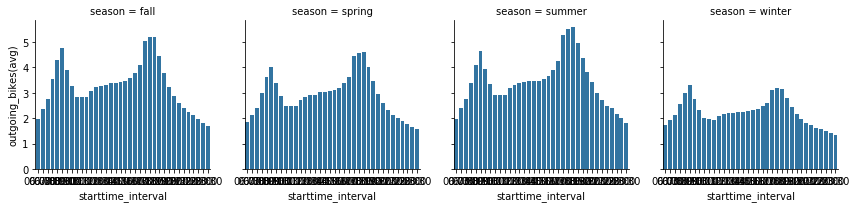

In [88]:
plt.figure(figsize=(16, 6))
g=sns.FacetGrid(outgoingDF.groupby(['season','starttime_interval'])['outgoing_bike_count'].mean().reset_index().\
                rename(columns={'outgoing_bike_count':'outgoing_bikes(avg)'}),col='season', margin_titles=True)
g.map(sns.barplot,'starttime_interval', 'outgoing_bikes(avg)')

<Figure size 1152x432 with 0 Axes>

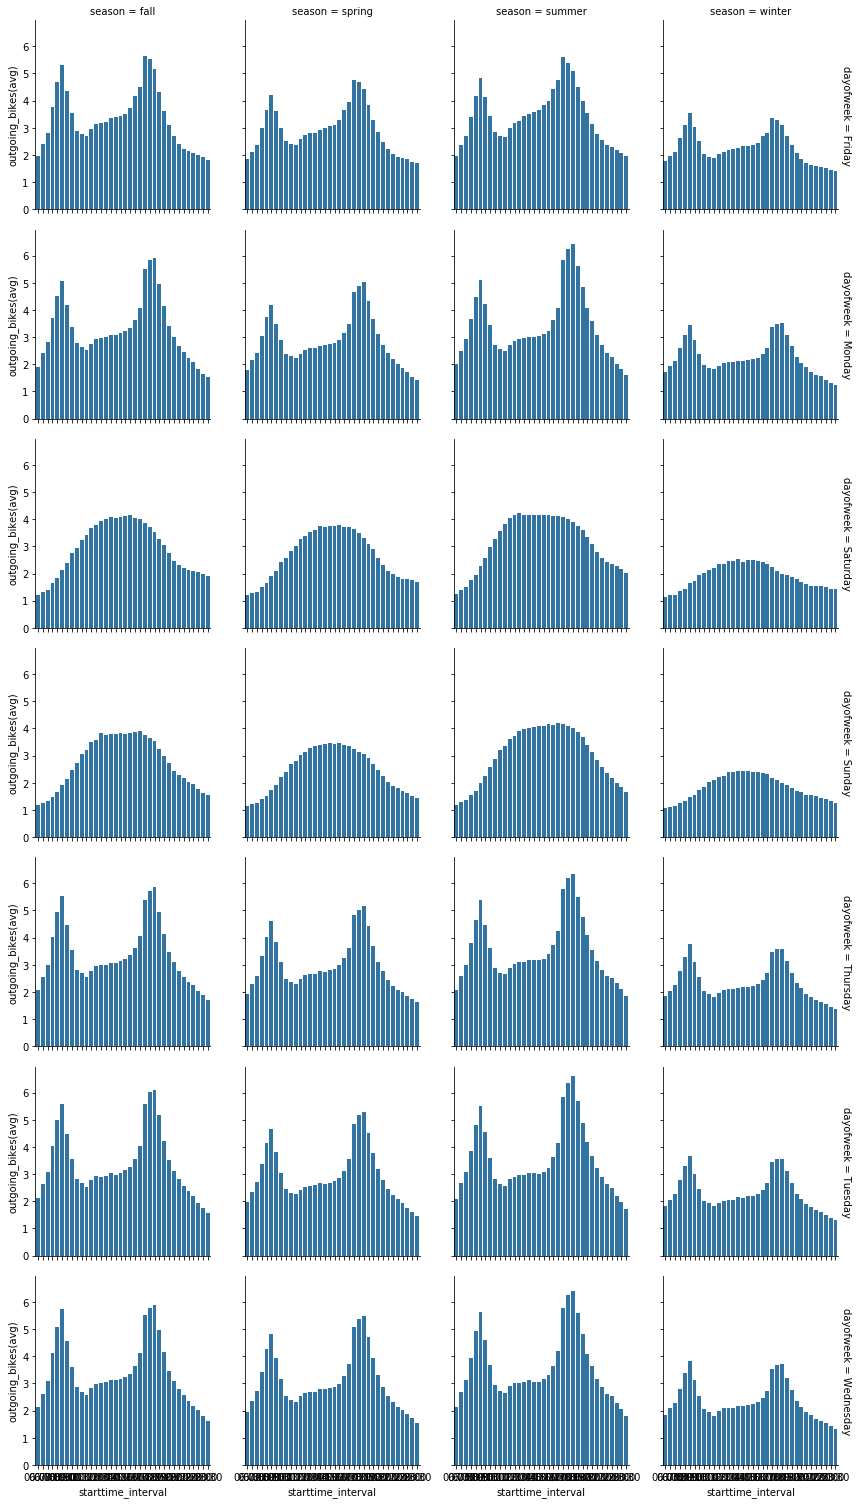

In [93]:
plt.figure(figsize=(16, 6))
g=sns.FacetGrid(outgoingDF.groupby(['season','dayofweek','starttime_interval'])['outgoing_bike_count'].mean().reset_index().\
                rename(columns={'outgoing_bike_count':'outgoing_bikes(avg)'}),row='dayofweek',col='season', margin_titles=True)
g.map(sns.barplot,'starttime_interval', 'outgoing_bikes(avg)')